# Kaggle MNIST Digit Recognition problem

In [1]:
from theano.sandbox import cuda
cuda.use('gpu2')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): Ignoring call to use(2), GPU number 0 is already in use.


In [2]:
%matplotlib inline

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Importing the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X_train = train.iloc[:, 1::].values
labels_train = train.iloc[:, 0].values
X_test = test.values

In [6]:
X_train.shape, X_test.shape

((42000, 784), (28000, 784))

In [5]:
# Feature Scaling (required for PCA and efficient for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Plotting sample images in test and train

In [6]:
# Reshaping train and test images
images_train = X_train.reshape(X_train.shape[0], 28, 28)
images_test = X_test.reshape(X_test.shape[0], 28, 28)

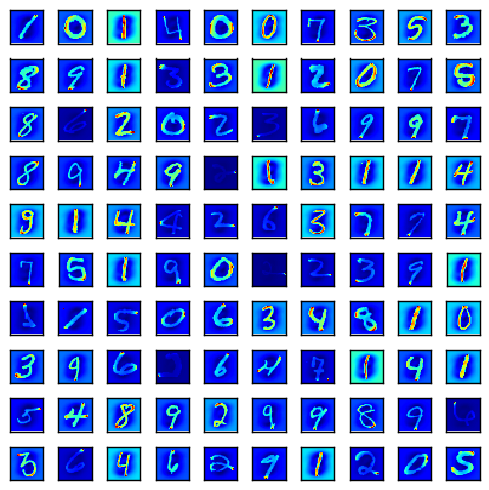

In [9]:
# Train images
plt.figure(figsize = (5, 5))
for i in range(0, 100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images_train[i], interpolation = "none")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

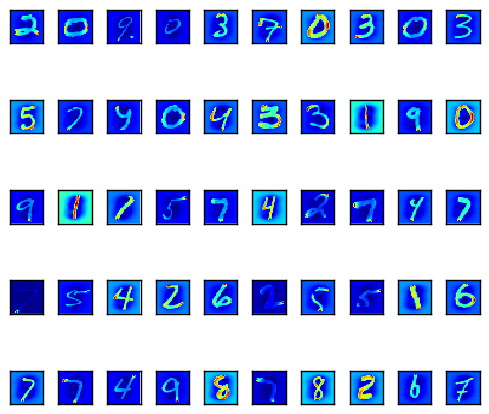

In [10]:
# Test images
plt.figure(figsize = (5, 5))
for i in range(0, 50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images_test[i], interpolation = "none")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [7]:
images_test = np.expand_dims(images_test,1)
images_train = np.expand_dims(images_train,1)

In [8]:
# Encoding for label variable for use in Neural Networks
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = [0])
labels_train_NN = onehotencoder.fit_transform(labels_train.reshape(-1,1)).toarray()

In [13]:
np.shape(labels_train_NN)

(42000, 10)

## Neural Network models - CNN and its variants

In [22]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K
K.set_image_dim_ordering('th')

### Model 1 : Simple stacked CNN architecture

In [48]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
model.compile(optimizer = 'nadam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 8, 8)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
__________

In [26]:
images_train.shape

(28000, 1, 28, 28)

In [31]:
model.optimizer.lr = 0.005

In [32]:
# Fitting the CNN to the Training Set
history = model.fit(images_train, labels_train_NN, validation_split = 0.1, batch_size = 100, epochs = 3)

Train on 37800 samples, validate on 4200 samples
Epoch 1/3
37800/37800 [==============================] - 6s - loss: 0.0122 - acc: 0.9957 - val_loss: 0.0373 - val_acc: 0.9900
Epoch 2/3
37800/37800 [==============================] - 6s - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0347 - val_acc: 0.9895
Epoch 3/3
37800/37800 [==============================] - 6s - loss: 0.0069 - acc: 0.9977 - val_loss: 0.0380 - val_acc: 0.9919


### Model 2 : Data Augmentation + BatchNorm/Dropout

In [41]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dense(768, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
        ])
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 24, 24)        96        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 8, 8)          36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 8, 8)          32        
__________

In [25]:
from keras.preprocessing import image

In [26]:
images_train = images_train.reshape(images_train.shape[0], 1, 28, 28)

In [27]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(images_train, labels_train_NN, test_size = 0.15)

In [28]:
X_train.shape

(35700, 1, 28, 28)

In [29]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_train, y_train, batch_size = 128)
val_batches = gen.flow(X_valid, y_valid, batch_size = 256)

In [32]:
val_batches

In [43]:
model.fit_generator(batches, (batches.n/batches.batch_size), epochs=5,
                   validation_data = val_batches, validation_steps = (val_batches.n/val_batches.batch_size))

Epoch 1/5
278/278 [==============================] - 94s - loss: 0.7597 - acc: 0.7607 - val_loss: 0.7756 - val_acc: 0.7364
Epoch 2/5
278/278 [==============================] - 94s - loss: 0.2667 - acc: 0.9167 - val_loss: 0.1899 - val_acc: 0.9403
Epoch 3/5
278/278 [==============================] - 94s - loss: 0.1863 - acc: 0.9432 - val_loss: 0.1563 - val_acc: 0.9514
Epoch 4/5
278/278 [==============================] - 94s - loss: 0.1467 - acc: 0.9549 - val_loss: 0.1075 - val_acc: 0.9646
Epoch 5/5
278/278 [==============================] - 94s - loss: 0.1310 - acc: 0.9589 - val_loss: 0.1387 - val_acc: 0.9588


In [19]:
model.optimizer.lr/ = 5

Elemwise{true_div,no_inplace}.0

In [30]:
def lr_iter(start, stop, div_step) :
    while start >= stop:
        yield start
        start/= div_step

In [44]:
for i in lr_iter(0.05, 0.002, 2):
    model.optimizer.lr = i
    print "Learning rate = "+str(i)
    model.fit_generator(batches, (batches.n/batches.batch_size), epochs=1,
                   validation_data = val_batches, validation_steps = (val_batches.n/val_batches.batch_size))

Learning rate = 0.05
Epoch 1/1
278/278 [==============================] - 94s - loss: 0.1144 - acc: 0.9651 - val_loss: 0.1039 - val_acc: 0.9664
Learning rate = 0.025
Epoch 1/1
278/278 [==============================] - 94s - loss: 0.1091 - acc: 0.9662 - val_loss: 0.1160 - val_acc: 0.9677
Learning rate = 0.0125
Epoch 1/1
278/278 [==============================] - 94s - loss: 0.0992 - acc: 0.9699 - val_loss: 0.0927 - val_acc: 0.9722
Learning rate = 0.00625
Epoch 1/1
278/278 [==============================] - 94s - loss: 0.0934 - acc: 0.9719 - val_loss: 0.0820 - val_acc: 0.9752
Learning rate = 0.003125
Epoch 1/1
278/278 [==============================] - 94s - loss: 0.0869 - acc: 0.9744 - val_loss: 0.0747 - val_acc: 0.9760


## Predicting results

In [27]:
labels_pred = model.predict_classes(images_test)

27936/28000 [============================>.] - ETA: 0s

In [28]:
# Writing the results to a csv file
np.savetxt('results.csv', labels_pred)

In [29]:
labels_pred[0:5,]

array([2, 0, 9, 0, 3])